In [3]:
import pandas as pd
import numpy as np

In [2]:
# Supongamos que ya has cargado el DataFrame 'df' desde el archivo CSV
df = pd.read_csv('spotify_dataset_sin_duplicados_4.csv')

In [ ]:
from gensim.models import Word2Vec
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
Word2Vec.seed = SEED

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocesar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-zA-Z\s]", "", texto)
    tokens = texto.split()
    return [t for t in tokens if t not in stop_words]

corpus = [preprocesar_texto(letra) for letra in df['text'].astype(str)]
modelo_w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4, seed=SEED)

def vector_promedio(tokens, modelo):
    vectores = [modelo.wv[word] for word in tokens if word in modelo.wv]
    return np.mean(vectores, axis=0) if vectores else np.zeros(modelo.vector_size)

letras_vectores = np.array([vector_promedio(tokens, modelo_w2v) for tokens in corpus])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\W11\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\W11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Limpieza de columna
df['Loudness (db)'] = df['Loudness (db)'].astype(str).str.replace('db', '', regex=False).astype(float)

columnas_numericas = [
    'Tempo', 'Loudness (db)', 'Energy', 'Danceability', 'Positiveness',
    'Speechiness', 'Liveness', 'Acousticness', 'Instrumentalness'
]

numericos_vectores = MinMaxScaler().fit_transform(df[columnas_numericas].fillna(0))


In [8]:
atributos_categoricos = df[['Genre', 'emotion', 'Explicit']].fillna('unknown')
categoricos_vectores = pd.get_dummies(atributos_categoricos).values

In [12]:
vectores_finales = np.concatenate([
    letras_vectores,
    numericos_vectores,
    categoricos_vectores
], axis=1)

NameError: name 'letras_vectores' is not defined

In [ ]:

# Guardar en formato Word2Vec compatible
with open("canciones_2_embeddings.txt", "w", encoding="utf-8") as f:
    f.write(f"{len(vectores_finales)} {vectores_finales.shape[1]}\n")
    for idx, vec in enumerate(vectores_finales):
        vector_str = ' '.join(map(str, vec))
        f.write(f"cancion_{idx} {vector_str}\n")


In [4]:
from gensim.models import KeyedVectors

# Cargar desde archivo
modelo_embeddings = KeyedVectors.load_word2vec_format("canciones_2_embeddings.txt", binary=False)

# Acceder a un embedding
print(modelo_embeddings['cancion_10'])

[ 0.37236145 -0.11784153 -0.538532   ...  0.          1.
  0.        ]


In [5]:
# Convertir la columna de fecha a datetime si no está
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

# Crear columna 'decade'
df['decade'] = df['Release Date'].dt.year // 10 * 10
df['decade'] = df['decade'].fillna(0).astype(int).astype(str) + 's'


In [14]:

# Obtener todos los vectores en orden
vectores_finales = np.array([modelo_embeddings[f"cancion_{i}"] for i in range(len(modelo_embeddings))])


In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_reducido = pca.fit_transform(vectores_finales)

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_reducido)
df['cluster'] = clusters


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette = silhouette_score(X_reducido, clusters)
calinski = calinski_harabasz_score(X_reducido, clusters)
davies = davies_bouldin_score(X_reducido, clusters)

print("📈 Métricas de evaluación del clustering:")
print(f"• Silhouette Score: {silhouette:.3f}")
print(f"• Calinski-Harabasz Index: {calinski:.2f}")
print(f"• Davies-Bouldin Index: {davies:.2f}")


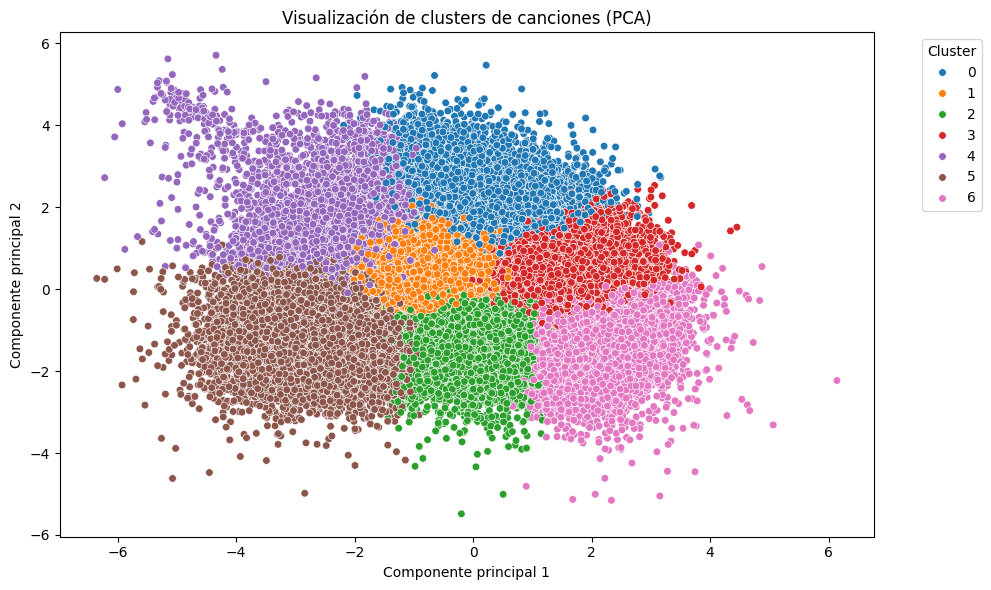

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reducido[:, 0], y=X_reducido[:, 1], hue=clusters, palette='tab10', s=30)
plt.title("Visualización de clusters de canciones (PCA)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

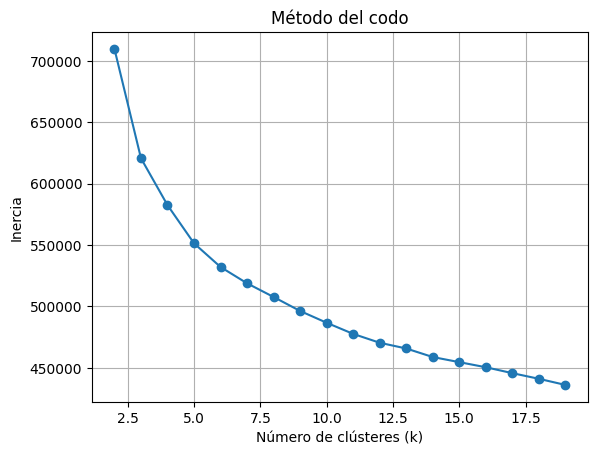

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inercia = []
K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reducido)
    inercia.append(kmeans.inertia_)

plt.plot(K_range, inercia, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import silhouette_score

mejor_score = -1
mejor_k = 2

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    etiquetas = kmeans.fit_predict(X_reducido)
    score = silhouette_score(X_reducido, etiquetas)
    print(f"k={k} → Silhouette: {score:.4f}")

    if score > mejor_score:
        mejor_score = score
        mejor_k = k

print(f"\n✅ Mejor número de clústeres según Silhouette: {mejor_k}")


k=2 → Silhouette: 0.2228
k=3 → Silhouette: 0.1823
k=4 → Silhouette: 0.1338
k=5 → Silhouette: 0.1249
k=6 → Silhouette: 0.1124
k=7 → Silhouette: 0.1077
k=8 → Silhouette: 0.0930
k=9 → Silhouette: 0.0904
k=10 → Silhouette: 0.0830
k=11 → Silhouette: 0.0788
k=12 → Silhouette: 0.0773
k=13 → Silhouette: 0.0752
k=14 → Silhouette: 0.0736
k=15 → Silhouette: 0.0734
k=16 → Silhouette: 0.0705
k=17 → Silhouette: 0.0685
k=18 → Silhouette: 0.0682
k=19 → Silhouette: 0.0686

✅ Mejor número de clústeres según Silhouette: 2


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def recomendar_por_cluster(id_cancion, df, X_total, top_n=5):
    cluster = df.loc[id_cancion, 'cluster']
    decada = df.loc[id_cancion, 'decade']
    misma_epoca = df[(df['cluster'] == cluster) & (df['decade'] == decada)].drop(index=id_cancion)

    vectores_cluster = X_total[misma_epoca.index]
    vector_base = X_total[id_cancion].reshape(1, -1)

    from sklearn.metrics.pairwise import cosine_similarity
    similitudes = cosine_similarity(vector_base, vectores_cluster)[0]
    top_indices = similitudes.argsort()[::-1][:top_n]
    recomendados = misma_epoca.iloc[top_indices]
    scores = similitudes[top_indices]

    return recomendados, scores

In [31]:
id_cancion = 8
recomendados, similitudes = recomendar_por_cluster(id_cancion, df, vectores_finales)
indices = recomendados.index

print("🔍 Canción base:")
print(f"{df.loc[id_cancion, 'song']} - {df.loc[id_cancion, 'Artist(s)']}")

print("\n🎧 Canciones recomendadas:")
for i, score in zip(indices, similitudes):
    print(f"{df.loc[i, 'song']} - {df.loc[i, 'Artist(s)']} (similitud: {score:.2f})")


🔍 Canción base:
The Hamilton Polka - "Weird Al" Yankovic

🎧 Canciones recomendadas:
Amish Paradise - "Weird Al" Yankovic (similitud: 0.92)
Drop the Mic w/ Usain Bolt - Kora (similitud: 0.91)
Say What You Want All Day Every Day Extended Mix - Texas (similitud: 0.91)
The Long One Trial Edit  Mix - 30 July 1969 - The Beatles (similitud: 0.91)
Rhymin and Rappin - Balla Et Ses Balladins (similitud: 0.91)


In [35]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from IPython.display import Image, display, HTML

# 🔐 Autenticación con la API de Spotify
client_id = "9d74d56ab0c5436ca827b968e647b1ca"
client_secret = "db476f73e50b473bac2fa02fe820e635"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

def obtener_html_portada(song_name, album_name, artist_name, genre=None, similitud=None, release_date_dataset=None, emotion=None):
    image_url = None
    spotify_release_date = "No disponible"

    # Nivel 1: track + album + artist
    query = f"track:{song_name} album:{album_name} artist:{artist_name}"
    result = sp.search(q=query, type='track', limit=1)

    if result['tracks']['items']:
        track = result['tracks']['items'][0]
        image_url = track['album']['images'][0]['url']
        spotify_release_date = track['album']['release_date']
    else:
        # Nivel 2: album + artist
        query = f"album:{album_name} artist:{artist_name}"
        result = sp.search(q=query, type='album', limit=1)
        if result['albums']['items']:
            album = result['albums']['items'][0]
            image_url = album['images'][0]['url']
            spotify_release_date = album['release_date']
        else:
            # Nivel 3: solo album
            query = f"album:{album_name}"
            result = sp.search(q=query, type='album', limit=1)
            if result['albums']['items']:
                album = result['albums']['items'][0]
                image_url = album['images'][0]['url']
                spotify_release_date = album['release_date']
            else:
                # Nivel 4: solo artist
                query = f"artist:{artist_name}"
                result = sp.search(q=query, type='artist', limit=1)
                if result['artists']['items']:
                    artist = result['artists']['items'][0]  # ✅ CORRECTO
                    if artist['images']:
                        image_url = artist['images'][0]['url']


    # Construir HTML
    if image_url:
        html = f"""
        <div style="display:inline-block; text-align:center; margin:10px; width:150px">
            <img src="{image_url}" width="150" style="border-radius:8px"><br>
            <b>{song_name}</b><br>
            <small>{artist_name}</small><br>
            <small>{genre if genre else ''}</small><br>
            <small>📅 {release_date_dataset}</small><br>
            <small>🗓 {spotify_release_date}</small><br>
            {'<small>🔗 %.2f</small>' % similitud if similitud else ''}<br>
            {'<small>🎭 %s</small>' % emotion if emotion else ''}
        </div>
        """
    else:
        html = f"""
        <div style="display:inline-block; text-align:center; margin:10px; width:150px">
            <div style="width:150px;height:150px;background:#ccc;border-radius:8px;"></div>
            <b>{song_name}</b><br>
            <small>{artist_name}</small><br>
            <small>No se encontró imagen</small>
        </div>
        """
    return html

# ✅ Reemplaza aquí con el ID de la canción base
id_cancion = 71732

# 🔍 Obtener información de la canción base
nombre_cancion = df.loc[id_cancion, 'song']
nombre_album = df.loc[id_cancion, 'Album']
artista = df.loc[id_cancion, 'Artist(s)']
genero = df.loc[id_cancion, 'Genre']
fecha = df.loc[id_cancion, 'Release Date']
emotion = df.loc[i, 'emotion']

# 🧠 Obtener recomendaciones usando vectores híbridos
recomendados, similitudes = recomendar_por_cluster(id_cancion, df, vectores_finales)
indices = recomendados.index


# ✅ Mostrar canción base
print("🔍 Canción base:")
print(f"{nombre_cancion} - {artista}\n")

# ✅ Mostrar portada de la canción base
html_cancion_base = obtener_html_portada(nombre_cancion, nombre_album, artista, genero, None, fecha, emotion)
display(HTML(html_cancion_base))

# ✅ Mostrar canciones recomendadas
print("🎧 Canciones recomendadas:")
html_resultados = ""

for i, sim in zip(indices, similitudes):
    nombre_cancion = df.loc[i, 'song']
    nombre_album = df.loc[i, 'Album']
    artista = df.loc[i, 'Artist(s)']
    genero = df.loc[i, 'Genre']
    fecha = df.loc[i, 'Release Date']
    emotion = df.loc[i, 'emotion']
    html_resultados += obtener_html_portada(nombre_cancion, nombre_album, artista, genero, sim, fecha, emotion)

# ✅ Mostrar resultados como una galería horizontal
display(HTML(html_resultados))

🔍 Canción base:
Drivers license - Olivia Rodrigo



🎧 Canciones recomendadas:


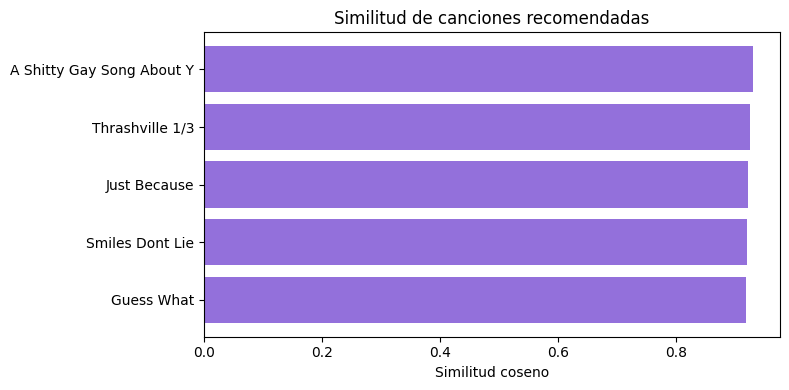

In [36]:
plt.figure(figsize=(8, 4))
plt.barh(range(len(similitudes)), sorted(similitudes, reverse=True), color='mediumpurple')
plt.yticks(range(len(similitudes)), [df.loc[i, 'song'][:25] for i in indices])
plt.xlabel('Similitud coseno')
plt.title('Similitud de canciones recomendadas')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [24]:
recomendaciones = pd.DataFrame({
    'Canción': [df.loc[i, 'song'] for i in indices],
    'Artista': [df.loc[i, 'Artist(s)'] for i in indices],
    'Género': [df.loc[i, 'Genre'] for i in indices],
    'Similitud': [round(score, 3) for score in similitudes]
})

display(recomendaciones)


,Canción,Artista,Género,Similitud
0,Rock Rock Till You Drop,Def Leppard,"rock,alternative rock,heavy metal",0.885
1,Rock and Roll Aint Noise Pollution,AC/DC,"rock,heavy metal,metal",0.885
2,Rock of Ages,Def Leppard,"rock,alternative rock,heavy metal",0.870
3,Rock 'n Roll Rebel,Ozzy Osbourne,"rock,heavy metal,metal",0.852
4,Built for Speed,Motörhead,"rock,heavy metal,metal",0.851
